# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import ilqr
from ilqr import iLQR
from ilqr.cost import QRCost, AutoDiffCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
##QR COST
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
## AUTODIFF COST
def l(x, u, i):
    xdiff = x - torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0])
    cost = xdiff.matmul(torch.from_numpy(Q).matmul(xdiff)) + u.matmul(torch.from_numpy(R).matmul(u))
    return cost.reshape(())
def l_terminal(x, i):
    xdiff = x - torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0])
    return xdiff.matmul(torch.from_numpy(Q_terminal).matmul(xdiff)).reshape(())
cost2 = AutoDiffCost(l, l_terminal, 5, 1)

In [9]:
N = 100
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))


In [40]:
ilqr = iLQR(dynamics, cost2, N)

In [41]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

torch.Size([5])
iteration 0 accepted 789.1658983911652 [ 0.01026043 -0.00559298 -2.82981338  0.00996383]
torch.Size([5])
iteration 1 accepted 761.3957617554815 [ 0.02805223 -0.01113958 -2.54127717  0.04350887]
torch.Size([5])
iteration 2 accepted 747.5892972680673 [ 0.03840147  0.08159246 -2.07787659  0.54653303]
torch.Size([5])
iteration 3 accepted 717.4032506485638 [-0.01635387  0.08304107 -2.03324134  0.36679164]
torch.Size([5])
iteration 4 accepted 708.0713558793567 [ 0.01345133  0.05654783 -2.01386158  0.26399413]
torch.Size([5])
iteration 5 accepted 695.7003197971405 [ 0.01500994  0.06156056 -1.97964019  0.22519363]
torch.Size([5])
iteration 6 accepted 693.3268362457218 [ 0.00785307  0.08961353 -2.01274131  0.11794032]
torch.Size([5])
iteration 7 accepted 691.8162882468419 [ 0.01333709  0.07912146 -1.98040075  0.1291174 ]
torch.Size([5])
iteration 8 accepted 686.8061706802292 [ 0.00351116  0.08898493 -1.97488308  0.09405531]
torch.Size([5])
iteration 9 accepted 686.1237576302387 

In [42]:
# Reduce the state to something more reasonable.
print(xs.shape)
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

(101, 5)


In [43]:
print(xs.shape)
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

(101, 4)


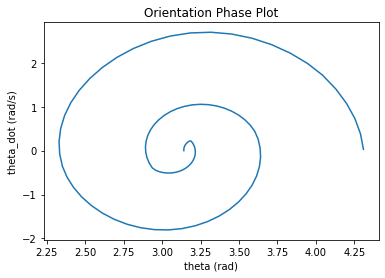

In [44]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

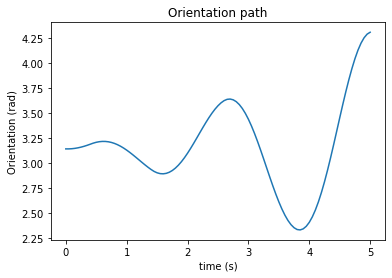

In [45]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

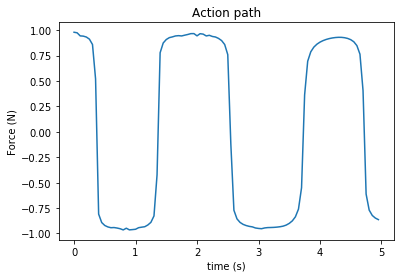

In [46]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

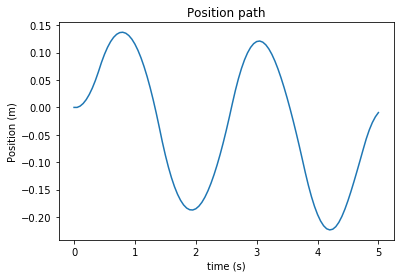

In [47]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

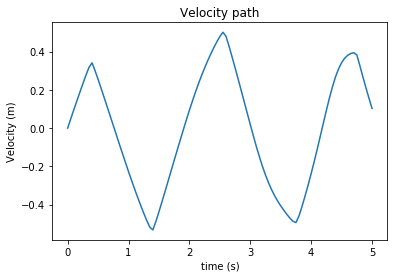

In [48]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

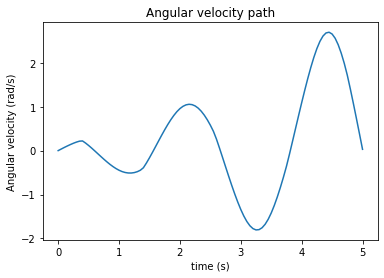

In [49]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

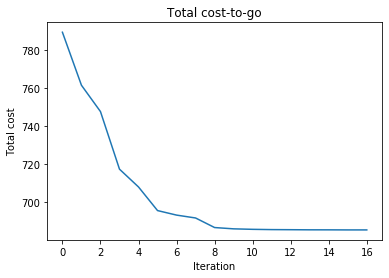

In [50]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [30]:
cost2.l_xx(x, u, 0, True)

array([[200.,   0.,   0.,   0.,   0.],
       [  0., 200.,   0.,   0.,   0.],
       [  0.,   0., 200.,   0.,   0.],
       [  0.,   0.,   0., 200.,   0.],
       [  0.,   0.,   0.,   0., 200.]])

In [31]:
cost1.l_ux(x, u, 0, True)

array([[0., 0., 0., 0., 0.]])

In [32]:
cost2.l_ux(x, u, 0, True)

array([[0., 0., 0., 0., 0.]])

In [33]:
cost1.l_uu(x, u, 0, True)

array([[0.]])

In [34]:
cost2.l_uu(x, u, 0, True)

array([[0.]])

In [31]:
from torch.autograd.functional import jacobian

In [37]:
jacobian(lambda x: l_terminal(x, 0), (torch.from_numpy(x),))[0].numpy()

array([-191.94841785,  -33.92687795,   60.36488364, -399.90446484,
       -188.88540373])